# Run PESTPP-IES

In this notebook we will run PESTPP-IES in standard, basic mode and then use buildin functionality for resolving prior-data conflict and estimating total error covariance

In [9]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu
%matplotlib inline

## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [10]:
num_workers = 20

In [11]:
t_d = "template_history"
m_d = "master_ies"

In [12]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d,check=False,forgive=False)

/Users/jwhite/Dev/gw1876/activities_stpete/notebooks/flopy/plot/map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


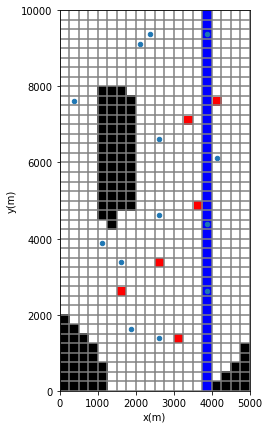

In [13]:
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.ModelMap(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

In [14]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
#pst.write_par_summary_table(filename="none")

### Run PESTPP-IES in original mode and post process

In [15]:
#pst.pestpp_options = {}
pst.pestpp_options["ies_num_reals"] = 50  # enough?
pst.pestpp_options["ies_par_en"] = "prior.jcb"
pst.pestpp_options["ies_bad_phi_sigma"] = 1.75
pst.pestpp_options["overdue_giveup_fac"] = 1.5
pst.pestpp_options["ies_save_rescov"] = True
pst.pestpp_options["ies_no_noise"] = True
pst.control_data.noptmax = 3



In [16]:
pst.write(os.path.join(t_d,"freyberg_ies.pst"))

noptmax:3, npar_adj:11873, nnz_obs:350


In [17]:
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg_ies.pst",num_workers=num_workers,master_dir=m_d)

A cheap phi progress plot

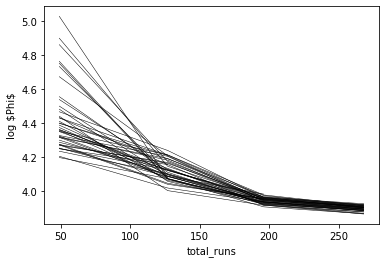

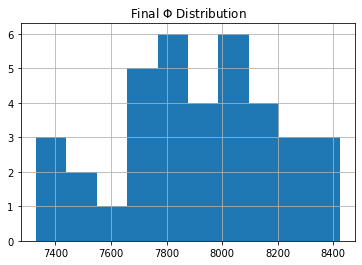

In [18]:
phi = pd.read_csv(os.path.join(m_d,"freyberg_ies.phi.actual.csv"),index_col=0)
phi.index = phi.total_runs
phi.iloc[:,6:].apply(np.log10).plot(legend=False,lw=0.5,color='k')
plt.ylabel('log \$Phi$')
plt.figure()
phi.iloc[-1,6:].hist()
plt.title('Final $\Phi$ Distribution');

Plot forecast prior and posterior histograms with "truth" (red line)

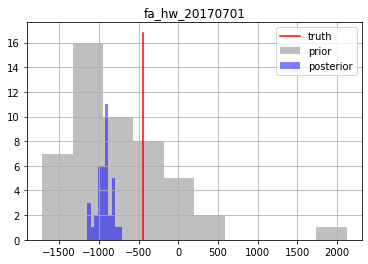

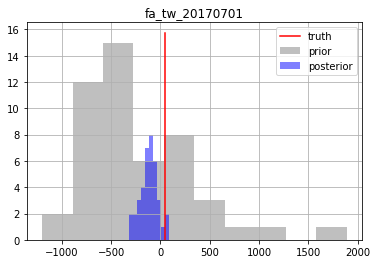

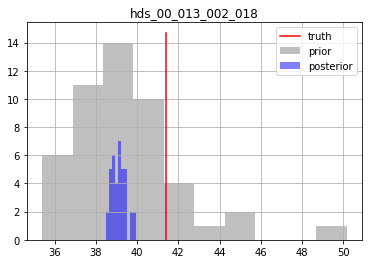

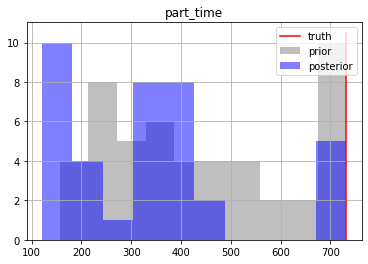

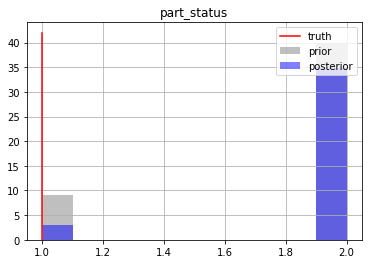

In [19]:
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5, label='prior')
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5, label='posterior')
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax.set_title(forecast)
    ax.legend(loc='upper right')
    plt.show()

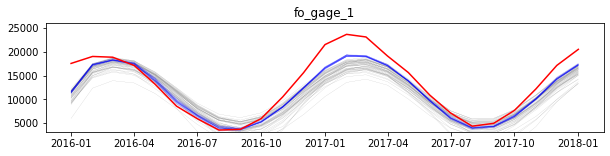

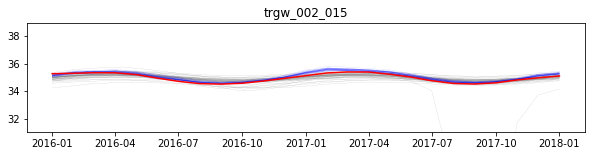

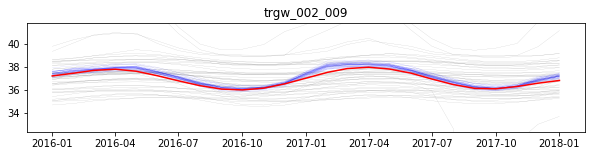

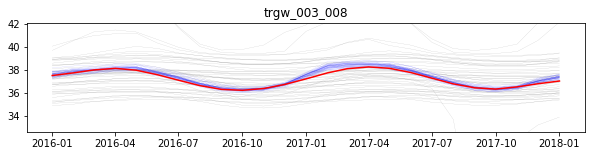

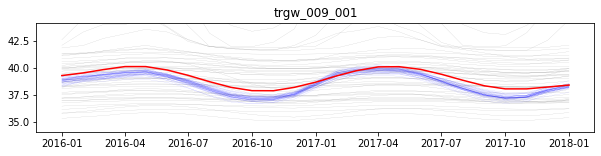

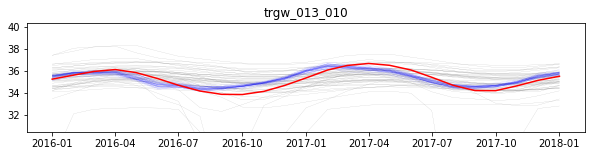

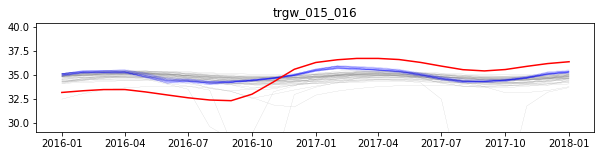

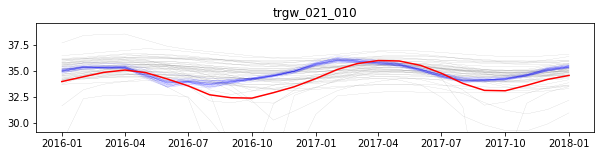

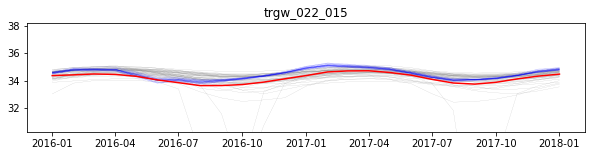

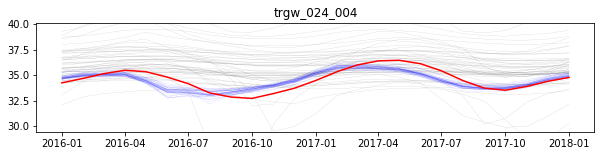

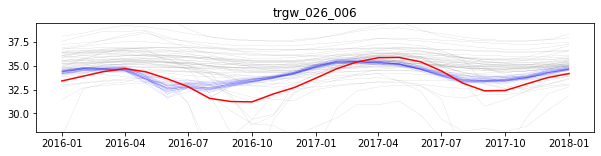

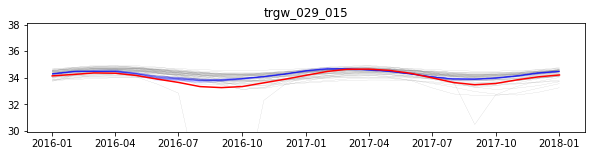

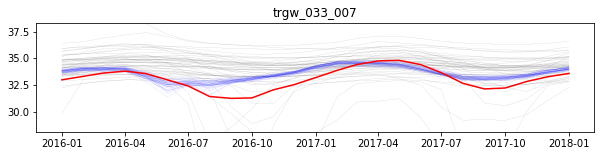

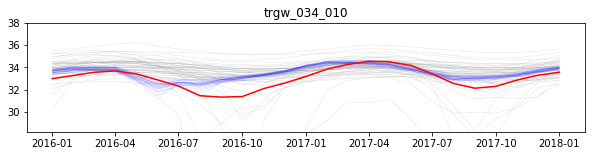

In [20]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
pst_base = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
oe_base = pd.read_csv(os.path.join(m_d,"freyberg_ies.base.obs.csv"),index_col=0)
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    
    [ax.plot(nz_obs_group.datetime,oe_pr.loc[r,nz_obs_group.obsnme],color="0.5",lw=0.1) for r in oe_pr.index]
    [ax.plot(nz_obs_group.datetime,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    #[ax.plot(nz_obs_group.datetime,oe_base.loc[r,nz_obs_group.obsnme],color="r",lw=0.1,alpha=0.5) for r in oe_base.index]
    mn = oe_base.loc[:,nz_obs_group.obsnme].min()
    mx = oe_base.loc[:,nz_obs_group.obsnme].max()
    
    ax.fill_between(nz_obs_group.datetime,mn,mx,fc="r",alpha=0.15)
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
    vmin = nz_obs_group.obsval.min() * 0.9
    vmax = nz_obs_group.obsval.max() * 1.1
    ax.set_ylim(vmin,vmax)
plt.show()

### Since we carried the final stress period sim water levels, we can now plot those just from the observation ensembles

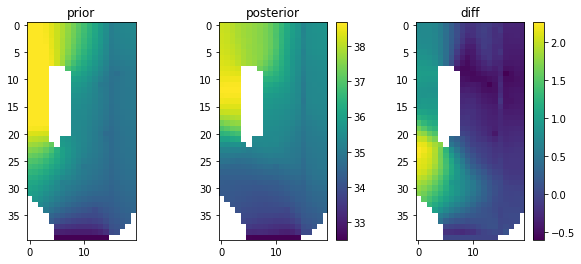

In [21]:
obs = pst.observation_data
hds_obs = obs.loc[obs.obsnme.apply(lambda x: x.startswith("hds_00") and x.endswith("{0:03d}".format(m.nper-1))),:].copy()
hds_obs.loc[:,"i"] = hds_obs.obsnme.apply(lambda x: int(x.split('_')[2]))
hds_obs.loc[:,"j"] = hds_obs.obsnme.apply(lambda x: int(x.split('_')[3]))
ib = m.bas6.ibound[0].array
def plot_real(real):
    pr_arr = np.zeros((m.nrow,m.ncol))
    pr_arr[hds_obs.i,hds_obs.j] = oe_pr.loc[real,hds_obs.obsnme]
    pt_arr = np.zeros((m.nrow,m.ncol))
    pt_arr[hds_obs.i,hds_obs.j] = oe_pt.loc[real,hds_obs.obsnme]
    pr_arr[ib==0] = np.NaN
    pt_arr[ib==0] = np.NaN
    
    vmin = min(np.nanmin(pr_arr),np.nanmin(pt_arr))
    vmax = min(np.nanmax(pr_arr),np.nanmax(pt_arr))
    
    d_arr = np.zeros((m.nrow,m.ncol))
    d_arr[hds_obs.i,hds_obs.j] = oe_pr.loc[real,hds_obs.obsnme] - oe_pt.loc[real,hds_obs.obsnme]
    d_arr[ib==0] = np.NaN
    fig,axes = plt.subplots(1,3,figsize=(10,4))
    axes[0].imshow(pr_arr,vmin=vmin,vmax=vmax)
    axes[0].set_title("prior")
    axes[1].set_title("posterior")
    axes[2].set_title("diff")
    cb = axes[1].imshow(pt_arr,vmin=vmin,vmax=vmax)
    plt.colorbar(cb,ax=axes[1])
    cb = axes[2].imshow(d_arr)
    plt.colorbar(cb,ax=axes[2])
    
    plt.show()
plot_real("base")

### We can also plot the first and second moments of the prior and posterior simulated water levels

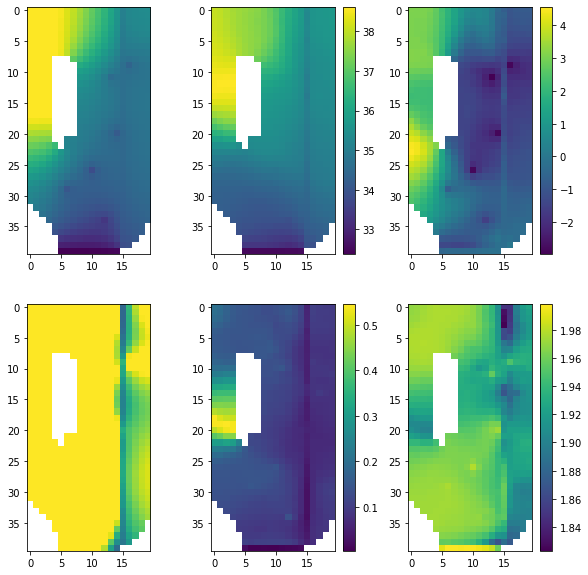

In [22]:
pr_mn = np.zeros((m.nrow,m.ncol))
pr_mn[hds_obs.i,hds_obs.j] = oe_pr.loc[:,hds_obs.obsnme].mean()
pt_mn = np.zeros((m.nrow,m.ncol))
pt_mn[hds_obs.i,hds_obs.j] = oe_pt.loc[:,hds_obs.obsnme].mean()
pr_std = np.zeros((m.nrow,m.ncol))
pr_std[hds_obs.i,hds_obs.j] = oe_pr.loc[:,hds_obs.obsnme].std()
pt_std = np.zeros((m.nrow,m.ncol))
pt_std[hds_obs.i,hds_obs.j] = oe_pt.loc[:,hds_obs.obsnme].std()
for a in [pr_mn,pr_std,pt_mn,pt_std]:
    a[ib==0] = np.nan

mnvmin = min(np.nanmin(pr_mn),np.nanmin(pt_mn))
mnvmax = min(np.nanmax(pr_mn),np.nanmax(pt_mn))
stvmin = min(np.nanmin(pr_std),np.nanmin(pt_std))
stvmax = min(np.nanmax(pr_std),np.nanmax(pt_std))
fig,axes = plt.subplots(2,3,figsize=(10,10))
axes[0,0].imshow(pr_mn,vmin=mnvmin,vmax=mnvmax)
cb = axes[0,1].imshow(pt_mn,vmin=mnvmin,vmax=mnvmax)
plt.colorbar(cb,ax=axes[0,1])
axes[1,0].imshow(pr_std,vmin=stvmin,vmax=stvmax)
cb = axes[1,1].imshow(pt_std,vmin=stvmin,vmax=stvmax)
plt.colorbar(cb,ax=axes[1,1])
cb = axes[0,2].imshow(100. * (pr_mn-pt_mn)/pr_mn)
plt.colorbar(cb,ax=axes[0,2])
cb = axes[1,2].imshow(np.log10(100. * (pr_std-pt_std)/pr_std))
plt.colorbar(cb,ax=axes[1,2])

Plot parameter histograms by group

<Figure size 576x756 with 0 Axes>

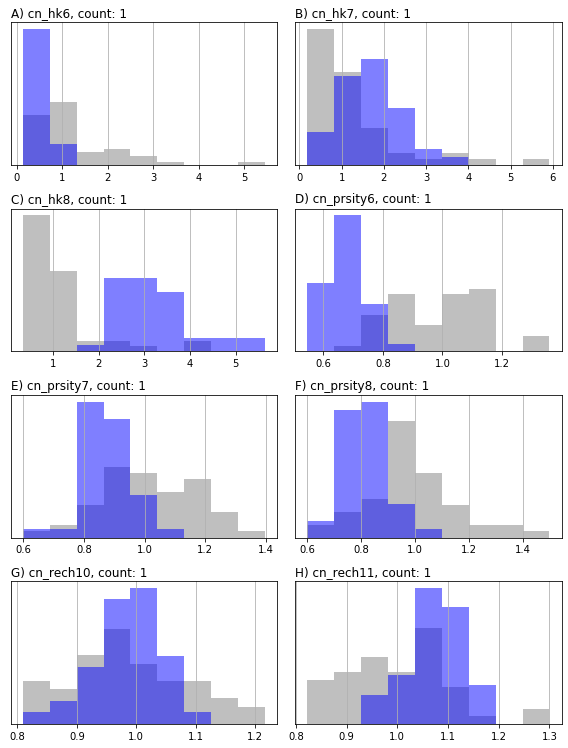

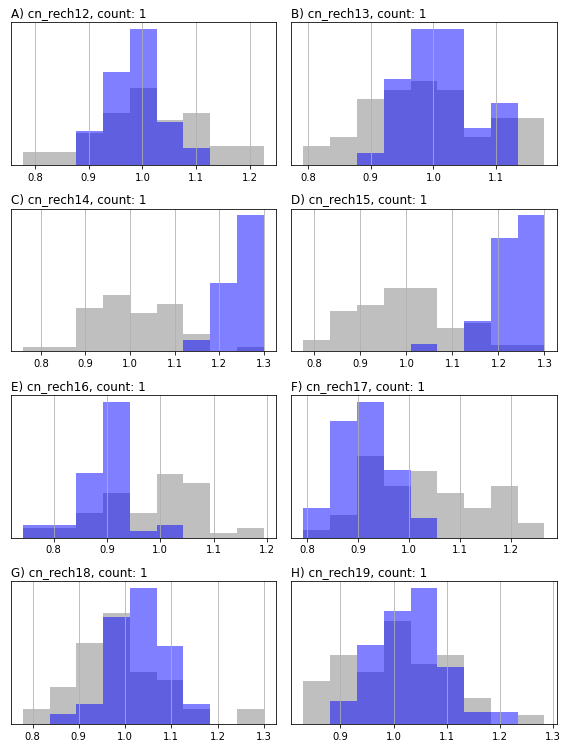

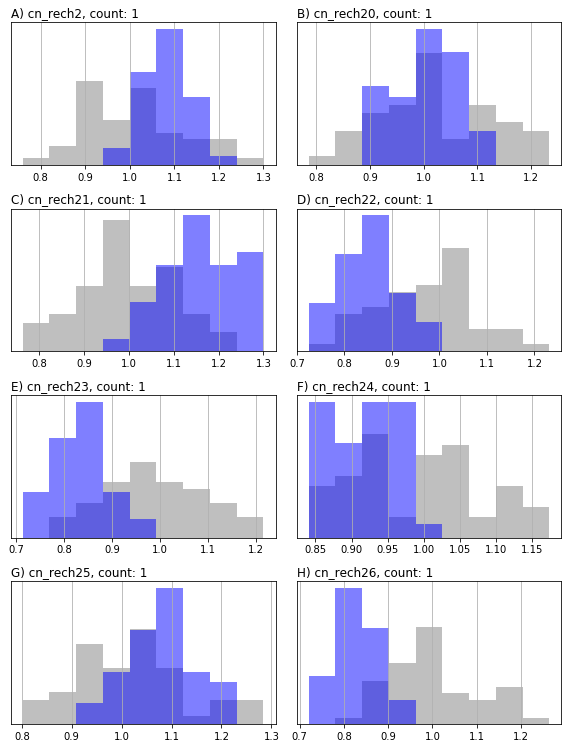

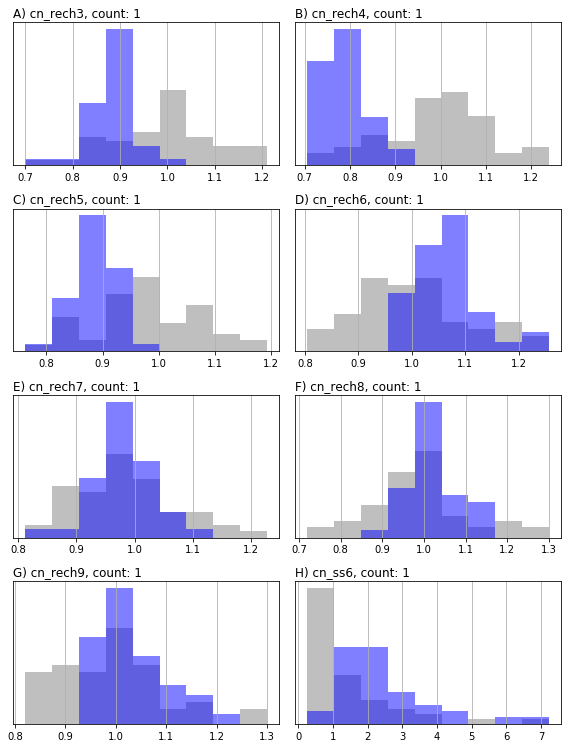

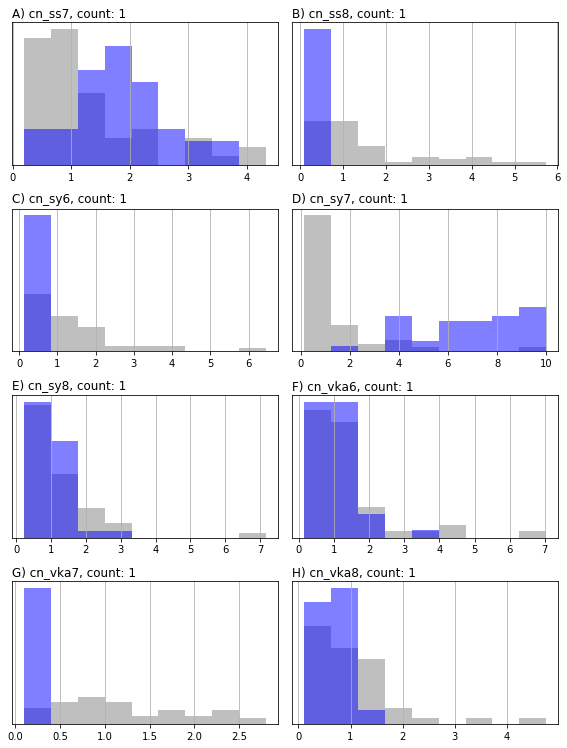

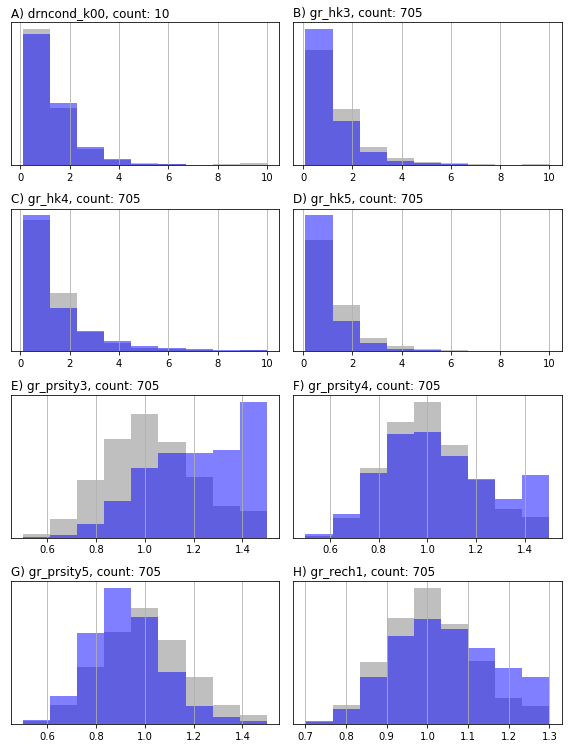

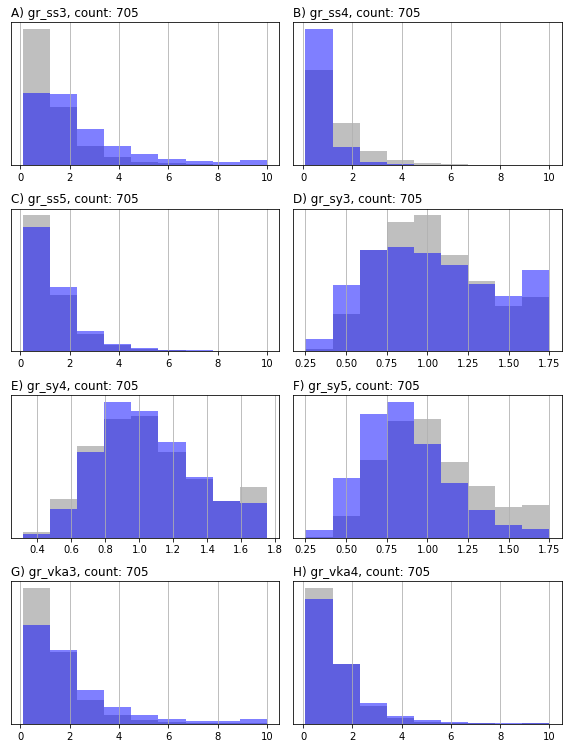

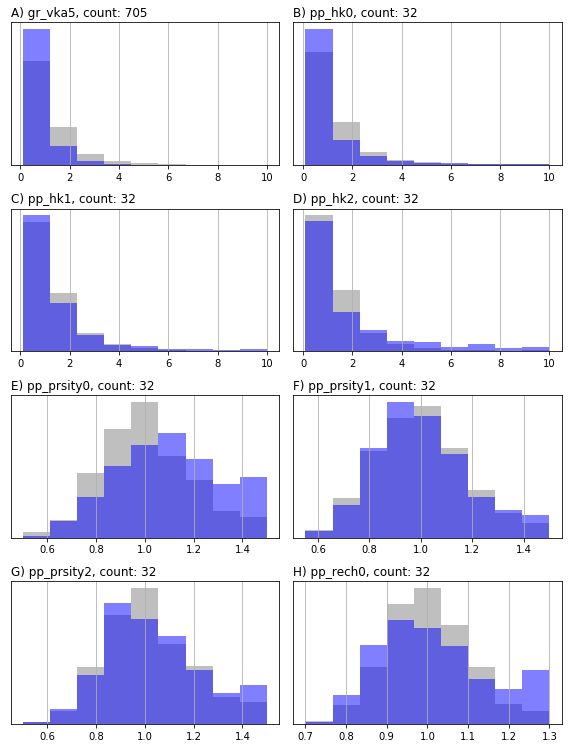

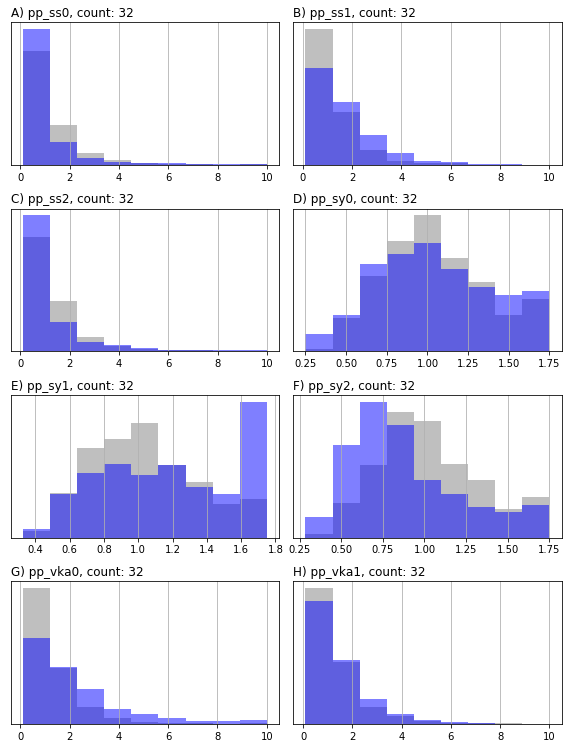

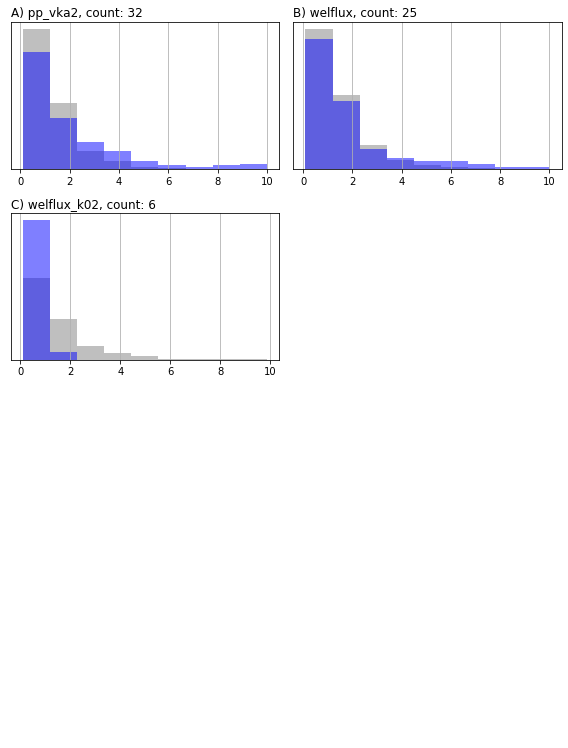

In [23]:
pe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.par.csv"),index_col=0)
pe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.par.csv".format(pst.control_data.noptmax)),index_col=0)
par = pst.parameter_data
pdict = par.groupby("pargp").groups
pyemu.plot_utils.ensemble_helper({"0.5":pe_pr,"b":pe_pt},plot_cols=pdict)

In [24]:
# pyemu.plot_utils.ensemble_change_summary(pe_pr,pe_pt,pst=pst,bins=20)
# par = pst.parameter_data
# li = par.partrans=="log"
# pe_pr.loc[:,li] = pe_pr.loc[:,li].apply(np.log10)
# pe_pr.shape

In [25]:
#TODO: demo reg in ies with maxsing and/or reg_fac   

### PESTPP-IES with automatic prior-data conflict resolution

Prior-data conflict, in the simpliest sense, means that simulated outputs from the prior parameter ensemble don't "cover" the observed values (plus optional measurement noise).  If the outputs from using lots of parameters and conservative (wide) parameter ranges (from the Prior) don't cover the observed values, then that implies we will need extreme parameter values (or extreme combinations) to reproduce these observations - another word for extreme is baised. So we shouldnt attempt parameter adjustments in the presence of prior-data conflict.  The easies way to deal with this is to simply not use conflicted observations for parameter adjustment calculations...PESTPP-IES will do this automatically for you:

In [26]:
pst.pestpp_options["ies_drop_conflicts"] = True
pst.pestpp_options["ies_pdc_sigma_distance"] = 2.0
pst.pestpp_options["ies_no_noise"] = True
pst.write(os.path.join(t_d,"freyberg_ies.pst"))

noptmax:3, npar_adj:11873, nnz_obs:350


In [27]:
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg_ies.pst",num_workers=num_workers,master_dir=m_d)

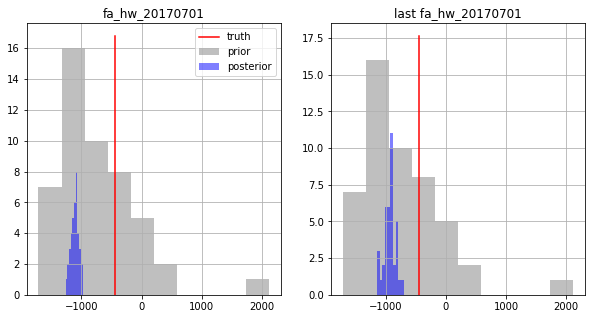

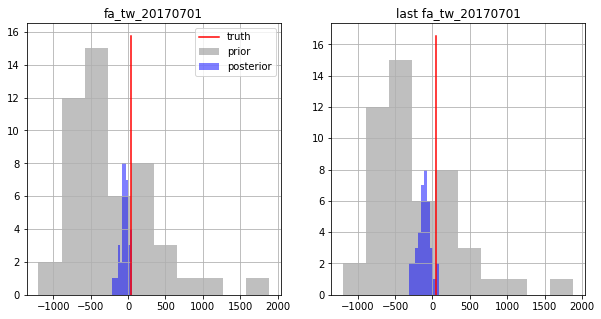

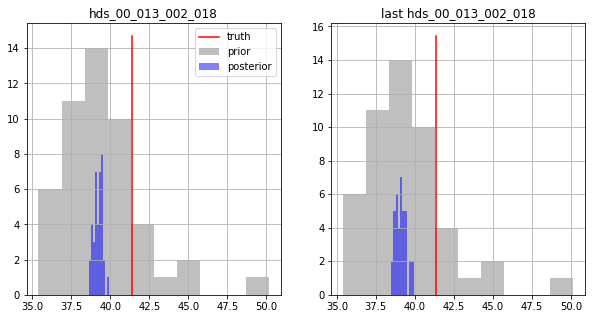

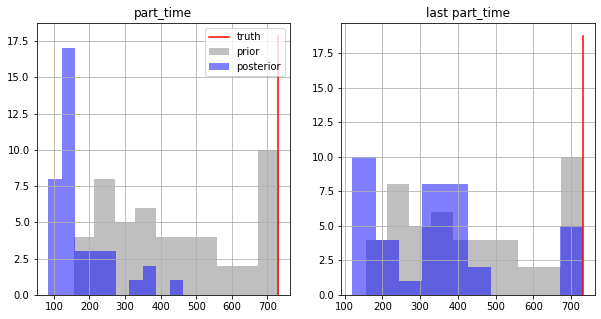

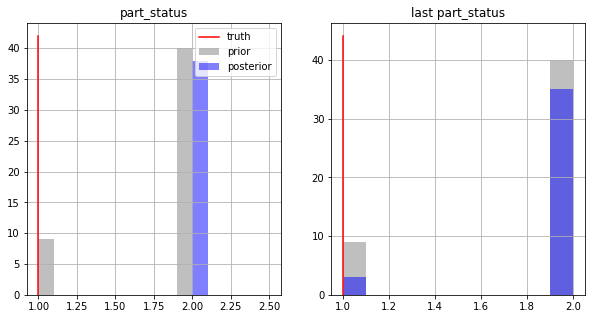

In [28]:
oe_pr_last = oe_pr.copy()
oe_pt_last = oe_pt.copy()
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    fig,[ax,ax_last] = plt.subplots(1,2,figsize=(10,5))
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5, label='prior')
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5, label='posterior')
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax.set_title(forecast)
    ax.legend(loc='upper right')
    
    oe_pr_last.loc[:,forecast].hist(ax=ax_last,color="0.5",alpha=0.5, label='prior')
    oe_pt_last.loc[:,forecast].hist(ax=ax_last,color="b",alpha=0.5, label='posterior')
    ax_last.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax_last.set_title("last " + forecast)
    ax.legend(loc='upper right')
    plt.show()

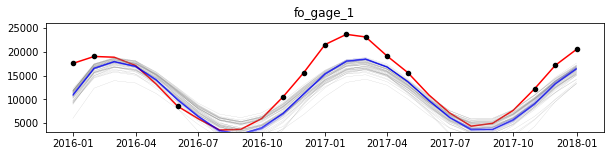

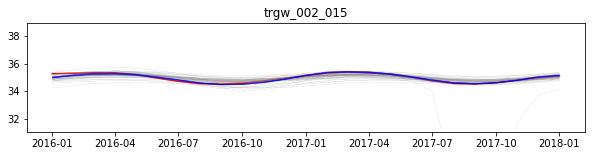

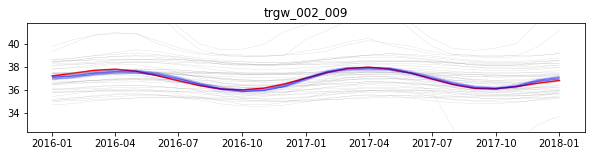

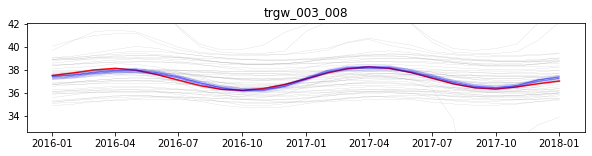

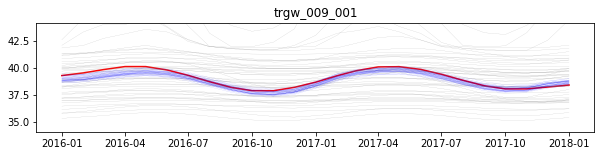

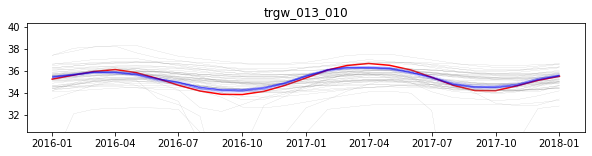

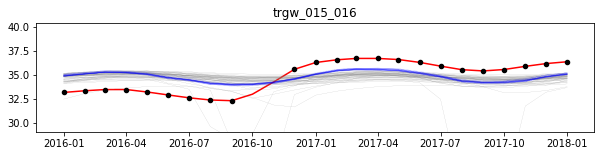

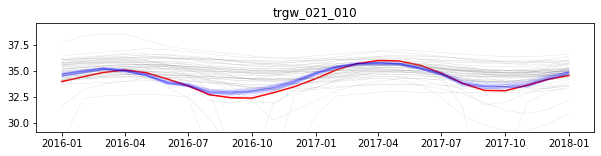

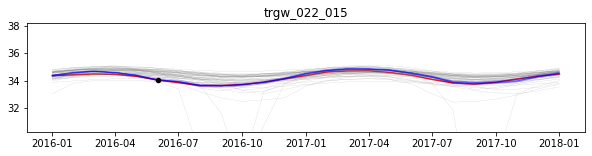

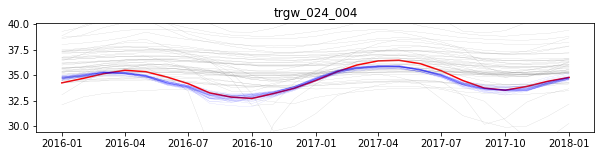

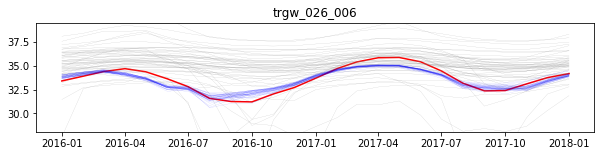

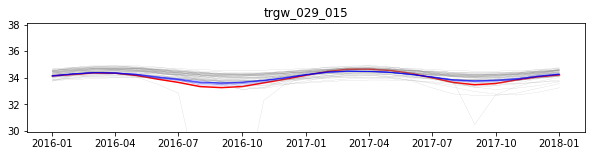

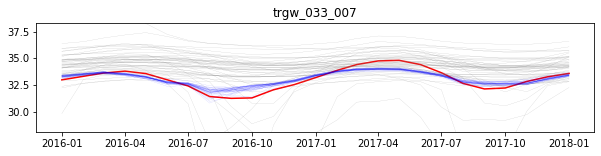

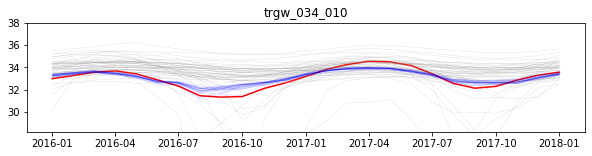

In [29]:
rw_obs = pd.read_csv(os.path.join(m_d,"freyberg_ies.adjusted.obs_data.csv"),index_col=0)
rw_obs = rw_obs.weight.to_dict()
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
pst_base = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
oe_base = pd.read_csv(os.path.join(m_d,"freyberg_ies.base.obs.csv"),index_col=0)
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    pdc_obs = nz_obs_group.loc[nz_obs_group.obsnme.apply(lambda x: rw_obs[x]==0),:]
   
    ax.scatter(pdc_obs.datetime,pdc_obs.obsval,marker='.',s=50,zorder=20,color='k',ls='-',lw=2,fc="k")
    [ax.plot(nz_obs_group.datetime,oe_pr.loc[r,nz_obs_group.obsnme],color="0.5",lw=0.1) for r in oe_pr.index]
    [ax.plot(nz_obs_group.datetime,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]
    #[ax.plot(nz_obs_group.datetime,oe_base.loc[r,nz_obs_group.obsnme],color="r",lw=0.1,alpha=0.5) for r in oe_base.index]
    mn = oe_base.loc[:,nz_obs_group.obsnme].min()
    mx = oe_base.loc[:,nz_obs_group.obsnme].max()
    
    ax.fill_between(nz_obs_group.datetime,mn,mx,fc="r",alpha=0.15)
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
    vmin = nz_obs_group.obsval.min() * 0.9
    vmax = nz_obs_group.obsval.max() * 1.1
    ax.set_ylim(vmin,vmax)
plt.show()

### PESTPP-IES in a total error covariance workflow

The concept of subjective weighting implies that the covariance measurement noise is itself uncertain (a hyper parameter).  Recently, it has been shown that this covariance matrix can be "estimated" in a outer iteration loop.  So let's do that!  First, lets look at the final (e.g. posterior) residual covariance matrix from the last run:

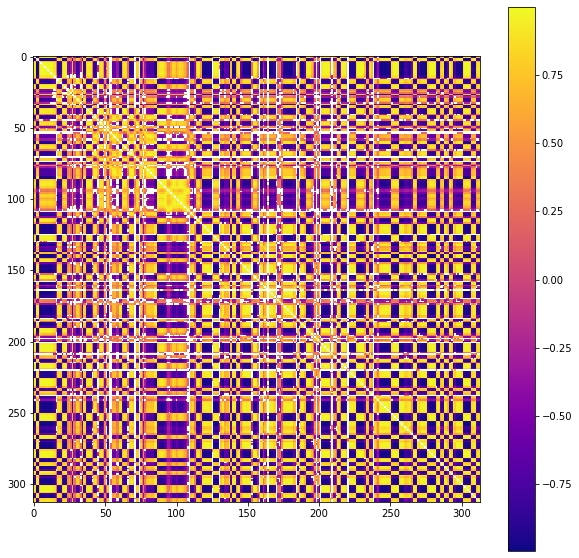

In [30]:
res_cov_file = os.path.join(m_d,"freyberg_ies.{0}.res.cov".format(pst.control_data.noptmax))
assert os.path.exists(res_cov_file)
#shutil.copy2(res_cov_file,os.path.join(t_d,"posterior_res.cov"))
res_cov = pyemu.Cov.from_ascii(res_cov_file)
x = res_cov.to_pearson().x.copy()
x[np.abs(x) < 0.2] = np.NaN
x[x==1.0] = np.NaN

fig,ax = plt.subplots(1,1,figsize=(10,10))
cb = ax.imshow(x,cmap="plasma")
plt.colorbar(cb)

That would make a nice bohemain rug pattern!  Seriously tho, we see lots of correlation between residuals...so much for the "independence" assumption..

So what should we do?  Well, let's feed that covariance matrix to PESTPP-IES for the next run (an "outer" iteration).

In [33]:
pst.pestpp_options["ies_drop_conflicts"] = False
pst.pestpp_options["ies_pdc_sigma_distance"] = 2.0
pst.pestpp_options["ies_no_noise"] = False
pst.observation_data.loc[:,"weight"] = [rw_obs[oname] for oname in pst.obs_names]
res_cov = res_cov.get(pst.nnz_obs_names)
res_cov.to_ascii(os.path.join(t_d,"obs.cov"))
pst.pestpp_options["obscov"] = "obs.cov"
pst.write(os.path.join(t_d,"freyberg_ies.pst"))

noptmax:3, npar_adj:11873, nnz_obs:313


In [34]:
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg_ies.pst",num_workers=num_workers,master_dir=m_d)

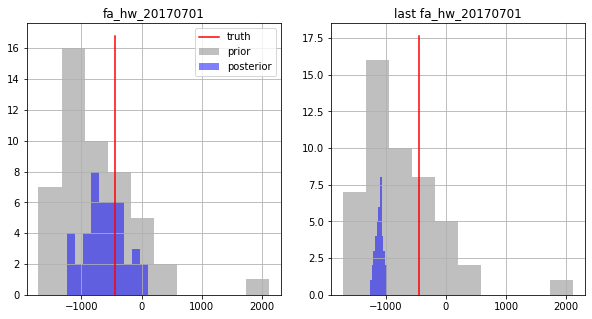

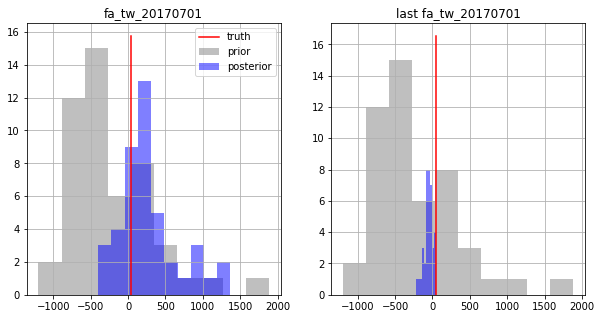

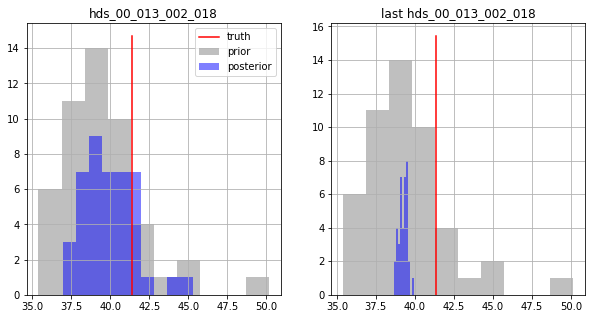

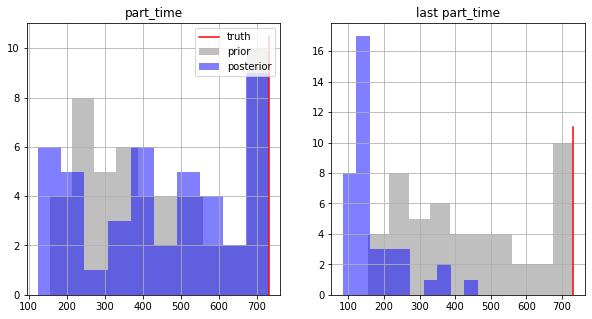

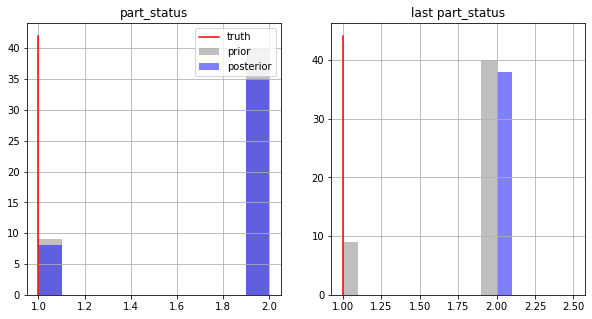

In [35]:
oe_pr_last = oe_pr.copy()
oe_pt_last = oe_pt.copy()
oe_pr = pd.read_csv(os.path.join(m_d,"freyberg_ies.0.obs.csv"),index_col=0)
oe_pt = pd.read_csv(os.path.join(m_d,"freyberg_ies.{0}.obs.csv".format(pst.control_data.noptmax)),index_col=0)
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    fig,[ax,ax_last] = plt.subplots(1,2,figsize=(10,5))
    oe_pr.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5, label='prior')
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5, label='posterior')
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax.set_title(forecast)
    ax.legend(loc='upper right')
    
    oe_pr_last.loc[:,forecast].hist(ax=ax_last,color="0.5",alpha=0.5, label='prior')
    oe_pt_last.loc[:,forecast].hist(ax=ax_last,color="b",alpha=0.5, label='posterior')
    ax_last.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r", label='truth')
    ax_last.set_title("last " + forecast)
    ax.legend(loc='upper right')
    plt.show()

In [ ]:
[f for f in os.listdir(m_d) if f.startswith("freyberg_ies") and f.endswith(".csv")]

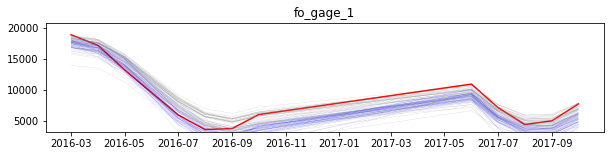

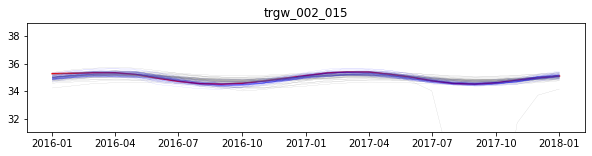

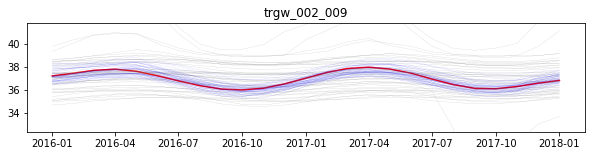

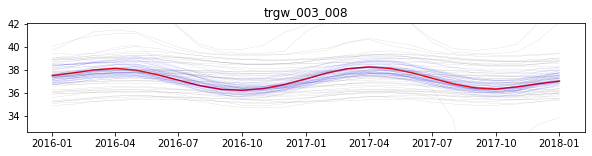

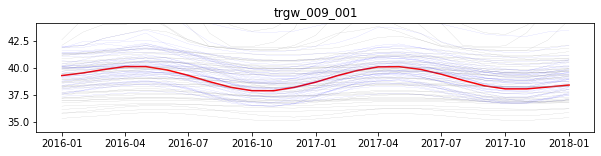

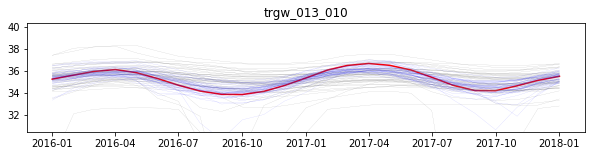

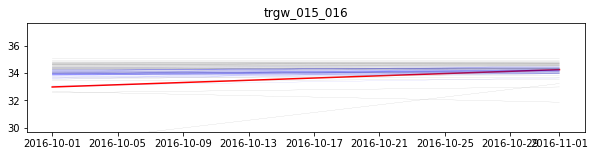

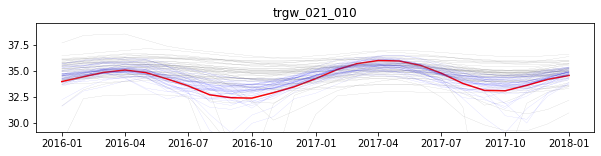

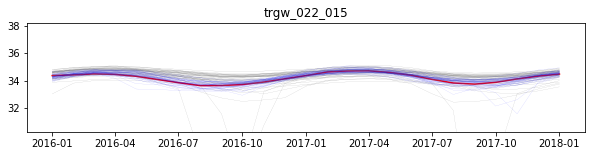

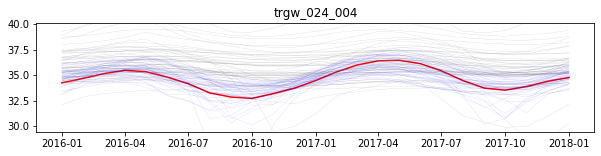

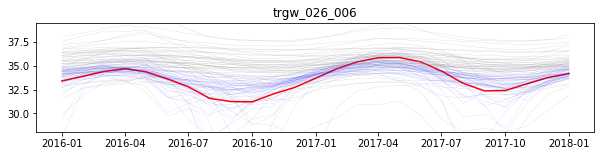

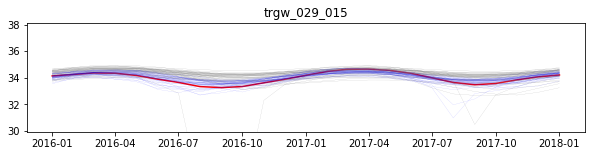

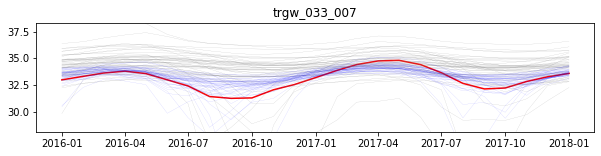

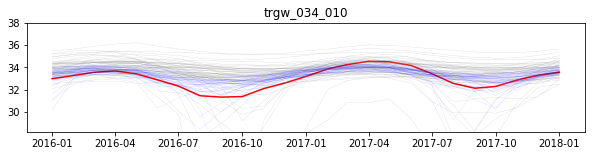

In [38]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
pst_base = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
oe_base = pd.read_csv(os.path.join(m_d,"freyberg_ies.base.obs.csv"),index_col=0)
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    pdc_obs = nz_obs_group.loc[nz_obs_group.obsnme.apply(lambda x: rw_obs[x]==0),:]
   
    ax.scatter(pdc_obs.datetime,pdc_obs.obsval,marker='.',s=50,zorder=20,color='k',ls='-',lw=2,fc="k")
    [ax.plot(nz_obs_group.datetime,oe_pr.loc[r,nz_obs_group.obsnme],color="0.5",lw=0.1) for r in oe_pr.index]
    [ax.plot(nz_obs_group.datetime,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]
    #[ax.plot(nz_obs_group.datetime,oe_base.loc[r,nz_obs_group.obsnme],color="r",lw=0.1,alpha=0.5) for r in oe_base.index]
    mn = oe_base.loc[:,nz_obs_group.obsnme].min()
    mx = oe_base.loc[:,nz_obs_group.obsnme].max()
    
    #ax.fill_between(nz_obs_group.datetime,mn,mx,fc="r",alpha=0.15)
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
    vmin = nz_obs_group.obsval.min() * 0.9
    vmax = nz_obs_group.obsval.max() * 1.1
    ax.set_ylim(vmin,vmax)
plt.show()